In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/wQuality.csv')
train_data.head()

,Unnamed: 0,text,corr,class
0,0,predatory white pointers dingos saltwatercrocs...,1,0
1,1,this january simply note that are still having...,1,0
2,2,pronouns hehim height zodiac sign leo smoke he...,1,0
3,3,pronouns hehim height zodiac sign sagittarius ...,1,0
4,4,hoses are inchworm water lilies are powderblue...,1,0


In [ ]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['text'].apply(lambda x:len(str(x).split())) 

In [ ]:
print('Info about training data:')
print(train_data['corr'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
1    19824
0    18981
Name: corr, dtype: int64
Total comments:  38805


In [ ]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :53


In [ ]:

num_words = 20000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['text'].values.astype(str).tolist())

In [ ]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['text'],\
                                                      train_data['corr'],\
                                                      test_size=0.3,\
                                                      random_state=0)

In [ ]:
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-9-9ee80a7500df>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-9-9ee80a7500df>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [ ]:
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [ ]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1]

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [ ]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

2894     1
36529    0
22543    0
4659     1
13624    1
4738     1
7        1
4296     1
24283    0
28095    0
Name: corr, dtype: int64
Text to number
[1 0 0 1 1 1 1 1 0 0]
Number to category
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# looking for top 30k comments
max_features = 20000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [ ]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
849/849 [==============================] - 32s 35ms/step - loss: 0.2282 - accuracy: 0.9147 - auc: 0.9793 - val_loss: 0.1750 - val_accuracy: 0.9472 - val_auc: 0.9907
Epoch 2/10
849/849 [==============================] - 23s 27ms/step - loss: 0.1501 - accuracy: 0.9591 - auc: 0.9942 - val_loss: 0.2025 - val_accuracy: 0.9327 - val_auc: 0.9874
Epoch 3/10
849/849 [==============================] - 23s 28ms/step - loss: 0.1424 - accuracy: 0.9686 - auc: 0.9961 - val_loss: 0.2171 - val_accuracy: 0.9381 - val_auc: 0.9885
Epoch 4/10
849/849 [==============================] - 21s 25ms/step - loss: 0.1287 - accuracy: 0.9774 - auc: 0.9978 - val_loss: 0.2494 - val_accuracy: 0.9441 - val_auc: 0.9872


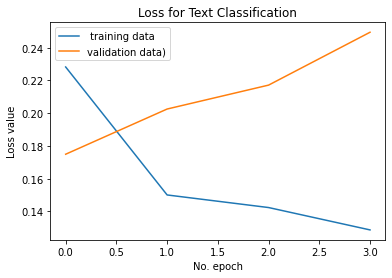

In [ ]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

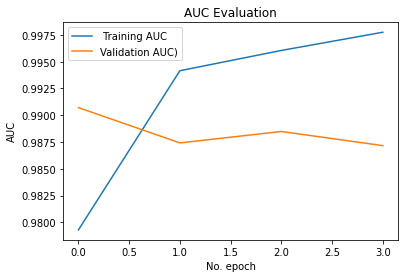

In [ ]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-21-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
364/364 [==============================] - 1s 4ms/step


array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
labels = [0, 1]
#labels = labels.values.astype(int).astype(str)
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5733
           1       0.96      0.92      0.94      5909

    accuracy                           0.94     11642
   macro avg       0.94      0.94      0.94     11642
weighted avg       0.94      0.94      0.94     11642

